In [201]:
from IPython.display import HTML
from matplotlib import animation, rc
from math import pi, cos, sin, acos, asin, atan2, sqrt
import numpy as np
from numpy import linalg as LA
import random
%matplotlib inline

In [286]:
# Constants
SAFE_ZONE = -1
PRED = "PRED"
PREY = "PREY"

In [309]:
# TODO Def can redesign the simulation to be more intutive with current functionality. Some game paradigms would be really helpful here
# as opposed to all the vector calc
# TODO So this is basically eye placement within a monty carlo simulation. I need to talk to an ecology person to get
# some ideas on actual animal behavior

In [490]:
# Create Eye Class
class Eye:
    def __init__(self, eye_arclength):
        # Height of the triangle
        self.direction = 8
        self.width = 6
        self.area = (self.direction * self.width)/2
        self.eye_arclength = eye_arclength

In [491]:
new_eye = Eye(pi/2)
assert new_eye.area == 24

In [492]:
# Create Grid
class Grid:
    def __init__(self):
        self.x_axis = 100
        self.y_axis = 100
    
    def print(self):
        print(grid)
    
    def valid_move(self, x, y):
        return(x > 0 and y > 0 and x + 1 <= self.x_axis and y + 1 <= self.y_axis)

A few problems to think about

How do I control where the eyes are located
How do I tell the direction the animal is facing
How do I allow the animal to move in relation to the direction its facing

Instead of doing a matrix format of the grid I'm going to do where the grid itself is just two numbers that represent the dimensions. The animal will operate in midpoints on movement.
Example:

Let location = [.5, .5]

If the animal moves left the value will be [1.5, .5]

The animal will also have a front point that will act to tell its direction.
The front point is an angle in relation to the x-axis.

Example:
Let front = PI
To calculate the front point we can then do cos(PI), sin(PI)

The eyes of the animal will be an arclength away from the front point.
Let front = PI
eye1_arclength = .5

Since the animal is essentially a unit circle:
front_arc_length = PI
eye1_arclength = PI + .5

Finding the point of the eye is then trivial
cos(eye1_arclength) + location[0], sin(eye1_arclength) + location[1]

Then looking is just a matter of building a triangle from the eye and finding if anything lies within it's area


The grid needs to know about all the animals so that it can tell when the game should be over. The grid is going to ask the animals for there location check and check for a winner at the end of each move

In [625]:
# Create Agent Action Class
class Animal:
    def __init__(self, eyes, role):
        self.role = role
        self.location = [.5,.5]
        self.direction_angle = (3*pi)/2
        # Eye Arc Lengths
        self.eyes = eyes
        self.score = 0
        
    # Returns tuples of ordered pairs for the location of the eyes
    def calc_eyes(self):
        # Calculate the position for an eye and return a tuple of the coordinates
        def calc_eye(eye):
            x = cos(abs(self.direction_angle + eye.eye_arclength)) + self.location[0]
            y = sin(abs(self.direction_angle + eye.eye_arclength)) + self.location[1]
            return((x, y))
        return(list(map(calc_eye, [eye for eye in self.eyes])))
         
    # The animal is allowed to turn it's body in any direction
    def turn(self, grid, angle, animal_found = False):
        self.direction_angle = (self.direction_angle + angle) % (2*pi)
    
    def decide_move(self, grid, angle, animal_found = False):
        random.seed()
        if(not animal_found):
            angle = random.uniform(0, 6.24)
            decided = random.choice([self.turn, self.move])
            decided(grid, angle, animal_found)
        else:
            self.move(grid, angle, animal_found)

    # The animal is allowed to move 1 in any direction
    def move(self, grid, angle, animal_found = False):
        if(animal_found and self.role == PREY):
            angle += pi
        x = cos(angle) + self.location[0]
        y = sin(angle) + self.location[1]
        if(grid.valid_move(x, y)):
            self.location[0] = x
            self.location[1] = y
            return True
        return False
    
#     # Look
#     def look():
#         for eye in calc_eyes():
            

In [626]:
# Tests - TODO Outdated
firstGrid = Grid()
pred = Animal(Eye, PREY)

# The animal turns correctly
pred.turn(pi)
assert pred.direction_angle == pi/2
# The animal moves correctly
pred.move(firstGrid, 2*pi)

assert pred.location[0] == cos(2*pi) + .5

TypeError: turn() missing 1 required positional argument: 'angle'

In [637]:
# Sim Control - Yea this is gonna have to be redone
class simulation_control():
    def __init__(self, Grid, Animal, prey_eyes, pred_eyes):
        self.grid = Grid()
        self.animals = [Animal(prey_eyes, PREY), Animal(pred_eyes, PRED)]
        self.safe_zone = ([20,15],[20,15])
        # Set the iterations
        self.iterations = 1
        for animal in self.animals:
            animal.location[0] = random.randint(1,20)
            animal.location[1] = random.randint(1,20)


    # Helper funcs
    def animal_in_area(self, triangle_vectors, current_animal):
        # Check if the animal is within the 3 points
        for animal in (set(self.animals).symmetric_difference(set([current_animal]))):
            vector_directions = []
            for vector in triangle_vectors:
                vector_directions.append(np.cross(animal.location, vector))
            normalized = [direction/sqrt(sum([direction**2 for direction in vector_directions])) for direction in vector_directions]
            direction = [normal > 0 for normal in normalized]
            return direction[0] == direction[1] == direction[2]
        # Not quite the most efficient way, but it'll do for now
    
    def turn(self, animal):
        other_animal_rel_location, distance = self.look(animal)
        # Look to see if that animal won or lost
        if(distance < 1.2 and animal.role == PRED):
            print("Prey caught")
            print(animal.location)
            for animal in self.animals:
                if(animal.role == PRED):
                    animal.score += 1
                else:
                    animal.score -= 1
            return(True)
        # Tell the animal to figure out where to move
        animal.decide_move(self.grid, other_animal_rel_location, not (other_animal_rel_location==False))
        return(False)
            
            
    def look(self, current_animal):
        for animal in self.animals:
            if(animal == current_animal):
                continue;
            angle = -1
            # Get the eye location area
            for eye in animal.calc_eyes():
                triangle_vectors = [(eye[0], eye[1]), (eye[0] + 8, eye[1] + 3), (eye[0] + 8, eye[1] - 3)]
                # Check if another animal is present
                if(self.animal_in_area(triangle_vectors, animal)):
                    # Tell that animal where the other animal is relative to it
                    angle = atan2(animal.location[1], animal.location[0])
                    distance = sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
                    return((angle, distance))
            return(False, 200)
                
            
    def animal_locations(self):
        return([animal.location for animal in self.animals])

    def ending_score(self, current_animal):
        for animal in self.animals:
            if animal == current_animal:
                continue;
            if(current_animal.role == PRED):
                current_animal.score -= sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
            else:
                current_animal.score += sqrt((animal.location[0] - current_animal.location[0])**2 + (animal.location[1] - current_animal.location[1])**2)
    
    def start_sim(self):
        # Run the iterations
        for iteration in range(self.iterations):
            for animal in self.animals:
                turn = self.turn(animal)
                c = "red" if animal.role != PREY else "blue"
                print(animal.role, ": ", animal.score, ": ", animal.location)
                plt.plot(animal.location[0], animal.location[1], 'ro', c=c, markersize=60)
                for eye in animal.calc_eyes():
                    print(eye)
                    plt.plot(eye[0], eye[1], 'ro', c="green", markersize=.9)
            if(turn):
                break;
        for animal in self.animals:
            self.ending_score(animal)
        plt.show()
        return(self.animals[0].score, self.animals[1].score)
            
        

-2.7737823872190424
PREY :  0 :  [10.07152330911474, 17.628609323645897]
(9.71195029102101, 18.5617262748685)
(9.073075238393251, 17.684299987787526)
PRED :  0 :  [5.49606587434472, 2.8682848889106665]
(4.751434852396911, 2.200808566369588)
(6.295108657336686, 3.469559061770647)


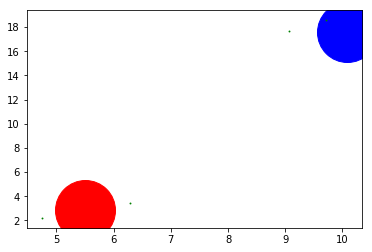

(15.453219346014412, -15.453219346014412)

In [639]:
eye_pair = (Evolve.random_eye_pair(), Evolve.random_eye_pair())
print(eye_pair[0][0].eye_arclength)
simulation_control(Grid, Animal, eye_pair[0], eye_pair[1]).start_sim()

In [559]:
class Evolve():
    def random_eye_pair():
        return((Eye(random.uniform(-6.24, 6.24)), Eye(random.uniform(-6.24, 6.24))))
    
    def breed_eye(eye_pair1, eye_pair2):
        return((Eye((eye_pair1[0].eye_arclength + eye_pair2[0].eye_arclength)/2), Eye((eye_pair1[1].eye_arclength + eye_pair2[1].eye_arclength)/2)))
    
    
    def mutate(eye_pair):
        chance_of_mutation = .01
        if random.random() < chance_of_mutation:
            eye_pair[0].eye_arclength += random.uniform(-6.24, 6.24)
            eye_pair[1].eye_arclength += random.uniform(-6.24, 6.24)
        return(eye_pair)

In [560]:
# So we are going to have a predator population that will one on one with a prey population at random
# The eye_placement for 1 and 2 will be random initally, but will undergo both breeding and mutation
init_pop = 50
prey_population = [Evolve.random_eye_pair() for item in range(init_pop)]
pred_population = [Evolve.random_eye_pair() for item in range(init_pop)]


In [561]:
simulation = [(eye_pair_pair[0], eye_pair_pair[1], simulation_control(Grid, Animal, eye_pair_pair[0], eye_pair_pair[1]).start_sim())  for eye_pair_pair in zip(prey_population, pred_population)]

PREY :  100.65362351583433
PRED :  -100.65362351583433
PREY :  49.165419224468266
PRED :  -49.165419224468266
PREY :  92.44024035243054
PRED :  -92.44024035243054
PREY :  32.75623456278587
PRED :  -32.75623456278587
PREY :  22.67209152620405
PRED :  -22.67209152620405
PREY :  95.59848045446742
PRED :  -95.59848045446742
PREY :  14.728857579339463
PRED :  -14.728857579339463
PREY :  104.68341760435257
PRED :  -104.68341760435257
PREY :  19.56680719101056
PRED :  -19.56680719101056
PREY :  87.42364807209661
PRED :  -87.42364807209661
PREY :  24.94579184667742
PRED :  -24.94579184667742
PREY :  119.6390220445047
PRED :  -119.6390220445047
PREY :  8.056537791334856
PRED :  -8.056537791334856
PREY :  114.59286651532084
PRED :  -114.59286651532084
PREY :  97.18460824182596
PRED :  -97.18460824182596
PREY :  94.72002251796155
PRED :  -94.72002251796155
PREY :  34.84856783483799
PRED :  -34.84856783483799
PREY :  6.442480248357158
PRED :  -6.442480248357158
PREY :  13.221906758658179
PRED :  -

In [562]:
simulation

[((<__main__.Eye at 0x1069096d8>, <__main__.Eye at 0x106909ba8>),
  (<__main__.Eye at 0x106909c88>, <__main__.Eye at 0x106452c18>),
  (100.65362351583433, -100.65362351583433)),
 ((<__main__.Eye at 0x1069099b0>, <__main__.Eye at 0x1069099e8>),
  (<__main__.Eye at 0x106452cc0>, <__main__.Eye at 0x106452240>),
  (49.165419224468266, -49.165419224468266)),
 ((<__main__.Eye at 0x1069095c0>, <__main__.Eye at 0x106909be0>),
  (<__main__.Eye at 0x1064522b0>, <__main__.Eye at 0x106452ac8>),
  (92.44024035243054, -92.44024035243054)),
 ((<__main__.Eye at 0x106909c50>, <__main__.Eye at 0x1069092e8>),
  (<__main__.Eye at 0x106452550>, <__main__.Eye at 0x106452e48>),
  (32.75623456278587, -32.75623456278587)),
 ((<__main__.Eye at 0x106909cf8>, <__main__.Eye at 0x106909fd0>),
  (<__main__.Eye at 0x106452748>, <__main__.Eye at 0x106452940>),
  (22.67209152620405, -22.67209152620405)),
 ((<__main__.Eye at 0x106909860>, <__main__.Eye at 0x106909a58>),
  (<__main__.Eye at 0x106452780>, <__main__.Eye at

In [572]:
# So we are going to have a predator population that will one on one with a prey population at random
# The eye_placement for 1 and 2 will be random initally, but will undergo both breeding and mutation
init_pop = 500
prey_population = [Evolve.random_eye_pair() for item in range(init_pop)]
pred_population = [Evolve.random_eye_pair() for item in range(init_pop)]
print(prey_population)
while(init_pop > 10):
    # Select 50% of the population
    results = [(eye_pair_pair[0], eye_pair_pair[1], simulation_control(Grid, Animal, eye_pair_pair[0], eye_pair_pair[1]).start_sim())  for eye_pair_pair in zip(prey_population, pred_population)]    
    prey_population = [result[0] for result in sorted(results, key=lambda result: result[2][0])[:int(init_pop*.5)]]
    pred_population = [result[1] for result in sorted(results, key=lambda result: result[2][1])[:int(init_pop*.5)]]

    #  Then select 10% randomly
    raw_prey = [result[0] for result in results]
    raw_pred = [result[1] for result in results]
    random.shuffle(raw_prey)
    random.shuffle(raw_pred)
    prey_population += raw_prey[:10]
    pred_population += raw_pred[:10]
    if(len(prey_population) % 2 != 0):
        prey_population.pop()
    if(len(pred_population) % 2 != 0):
        pred_population.pop()
    half_index = int(len(prey_population)/2)
    prey_pairs = zip(prey_population[:half_index], prey_population[half_index:])
    pred_pairs = zip(pred_population[:half_index], pred_population[half_index:])

    init_pop = init_pop * .6
    if(init_pop <= 10):
        break
    # Eyes mix
    child_eye_preys = [Evolve.breed_eye(eye_pair[0], eye_pair[1]) for eye_pair in prey_pairs]
    child_eye_preds = [Evolve.breed_eye(eye_pair[0], eye_pair[1]) for eye_pair in pred_pairs]
    prey_population = [Evolve.mutate(eye_pair) for eye_pair in child_eye_preys + child_eye_preys[:9]]
    pred_population = [Evolve.mutate(eye_pair) for eye_pair in child_eye_preds + child_eye_preds[:9]]
    # Run them through potential mutation


[(<__main__.Eye object at 0x1067f8588>, <__main__.Eye object at 0x1067f8eb8>), (<__main__.Eye object at 0x1067f8240>, <__main__.Eye object at 0x1067f8d68>), (<__main__.Eye object at 0x1067f8a58>, <__main__.Eye object at 0x1067f8470>), (<__main__.Eye object at 0x1067f8160>, <__main__.Eye object at 0x1067f8e80>), (<__main__.Eye object at 0x1067f8518>, <__main__.Eye object at 0x1067f8208>), (<__main__.Eye object at 0x1067f84a8>, <__main__.Eye object at 0x1067f8fd0>), (<__main__.Eye object at 0x1067f8b00>, <__main__.Eye object at 0x1067f8320>), (<__main__.Eye object at 0x1067f8748>, <__main__.Eye object at 0x1067f88d0>), (<__main__.Eye object at 0x1067f8da0>, <__main__.Eye object at 0x1067f8c88>), (<__main__.Eye object at 0x1067f89b0>, <__main__.Eye object at 0x1067f8400>), (<__main__.Eye object at 0x1067f8ac8>, <__main__.Eye object at 0x1067f8c18>), (<__main__.Eye object at 0x1067f8048>, <__main__.Eye object at 0x1067f86a0>), (<__main__.Eye object at 0x1067f8940>, <__main__.Eye object at 

Prey caught
[7.631297320440243, 8.775540903631116]
Prey caught
[0.4247943161821265, 2.217709392091771]
Prey caught
[8.119528940070685, 12.653553070718559]
Prey caught
[10.55929916790747, 19.562288075564698]
Prey caught
[12.593924110484947, 17.804521069323027]
Prey caught
[8.32681073823737, 11.254311389955326]
Prey caught
[17.660279639316727, 5.817076300131466]
Prey caught
[1.3370227657461413, 13.23699029372083]
Prey caught
[16.912759171054553, 10.894800526884469]
Prey caught
[16.372794417350296, 13.456215170017641]
Prey caught
[1.7032325565734778, 7.870409998163751]
Prey caught
[10.984366061642811, 7.562252182887499]
Prey caught
[20.54639021126299, 10.285689961078745]
Prey caught
[4.688825216570312, 8.579390969131355]
Prey caught
[9.611256638942276, 17.271085390531304]
Prey caught
[5.419966783139301, 11.535391835482635]
Prey caught
[8.68967176967683, 15.214883818360269]
Prey caught
[10.820732954925209, 4.827605888602369]
Prey caught
[8.122905102905984, 8.575947423580933]
Prey caught
[1

In [571]:
eye_lengths = [(eye_pair[0].eye_arclength, eye_pair[1].eye_arclength) for eye_pair in pred_population]

[(-0.7897545925747494, -0.09516155129146871),
 (-0.39209900626412014, -0.10457040033951781),
 (-0.3937751916646841, -0.07997581135352616),
 (-0.6608882586410904, -0.04709410117825547),
 (-0.7464790380870561, -0.05168493223103515),
 (-0.7464790380870561, -0.05168493223103515),
 (-1.0418004961835874, 0.01576845696238979),
 (-0.6608882586410904, -0.04709410117825547),
 (-0.7897545925747494, -0.09516155129146871),
 (-0.39209900626412014, -0.10457040033951781),
 (-0.3937751916646841, -0.07997581135352616),
 (-0.6608882586410904, -0.04709410117825547),
 (-0.7464790380870561, -0.05168493223103515),
 (-0.7464790380870561, -0.05168493223103515),
 (-1.0418004961835874, 0.01576845696238979),
 (-0.6608882586410904, -0.04709410117825547)]

In [573]:
results[0]

((<__main__.Eye at 0x101c17b00>, <__main__.Eye at 0x101c17080>),
 (<__main__.Eye at 0x105dfa9b0>, <__main__.Eye at 0x105dfa6d8>),
 (85.38003975565279, -85.38003975565279))

Prey Results
Score:  -85.38003975565279


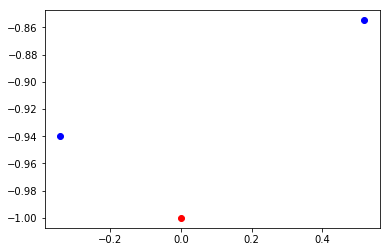

Pred Results
Score:  85.38003975565279


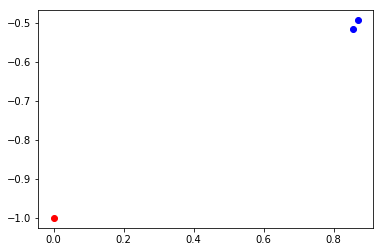

Prey Results
Score:  -30.429703109300906


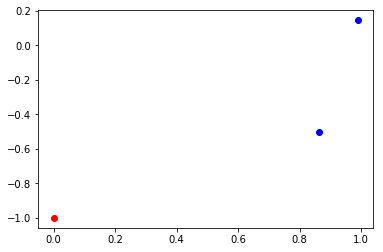

Pred Results
Score:  30.429703109300906


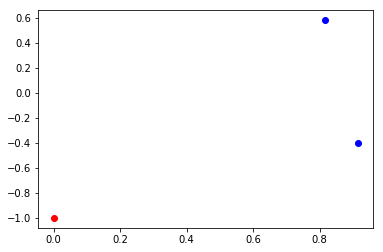

Prey Results
Score:  -77.75231391624116


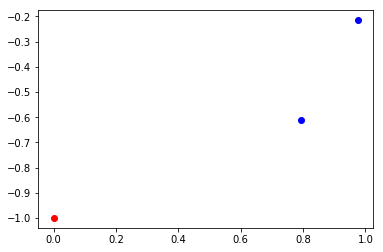

Pred Results
Score:  77.75231391624116


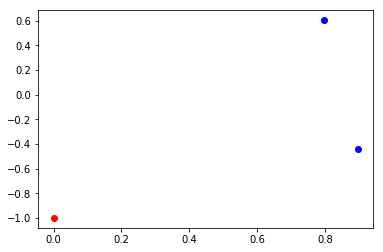

Prey Results
Score:  -18.175642166663295


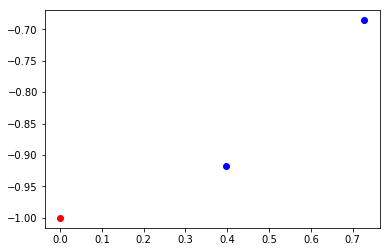

Pred Results
Score:  18.175642166663295


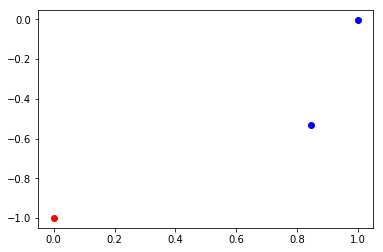

Prey Results
Score:  -42.788908020545826


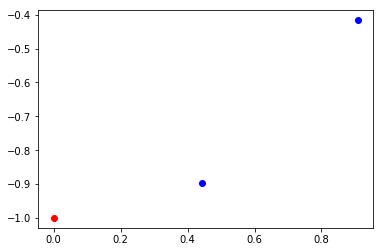

Pred Results
Score:  42.788908020545826


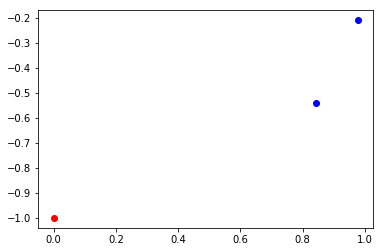

Prey Results
Score:  -89.9166009163679


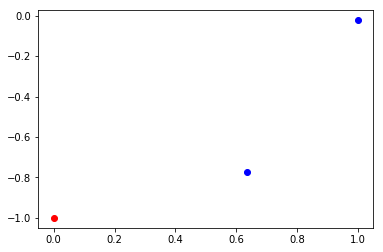

Pred Results
Score:  89.9166009163679


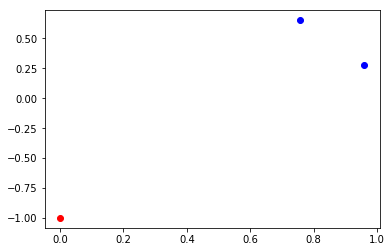

Prey Results
Score:  -94.59656565013049


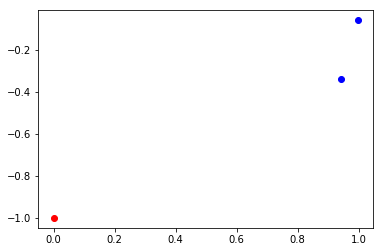

Pred Results
Score:  94.59656565013049


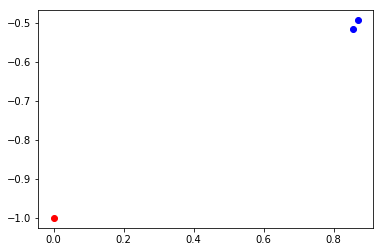

Prey Results
Score:  -91.65067138293318


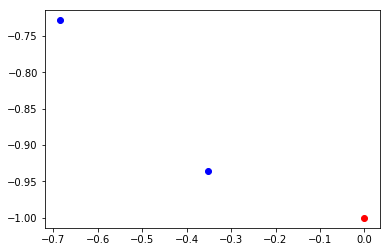

Pred Results
Score:  91.65067138293318


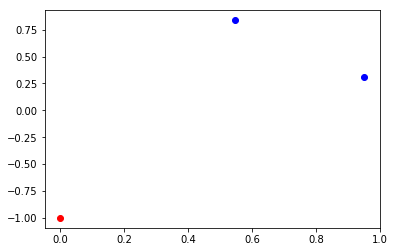

Prey Results
Score:  -91.2014962111449


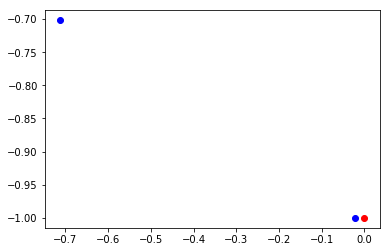

Pred Results
Score:  91.2014962111449


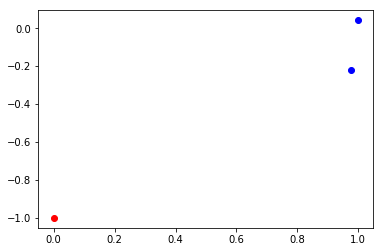

Prey Results
Score:  -20.314410318014694


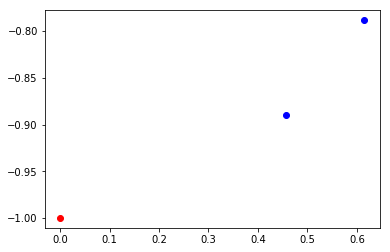

Pred Results
Score:  20.314410318014694


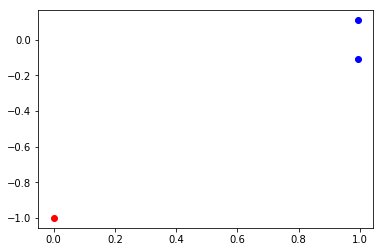

Prey Results
Score:  -19.88010632806727


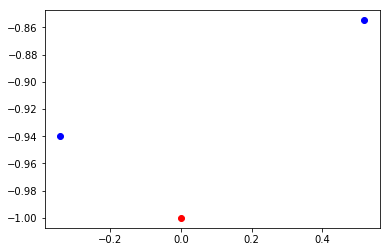

Pred Results
Score:  19.88010632806727


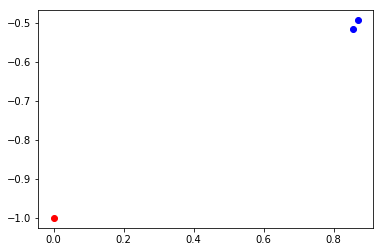

Prey Results
Score:  -20.97908346418367


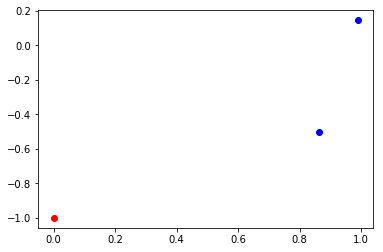

Pred Results
Score:  20.97908346418367


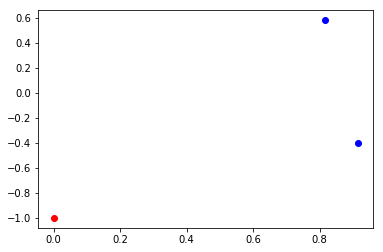

Prey Results
Score:  -91.49026324561937


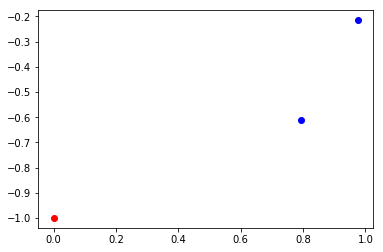

Pred Results
Score:  91.49026324561937


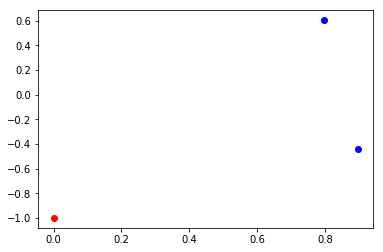

Prey Results
Score:  -7.4412439119948575


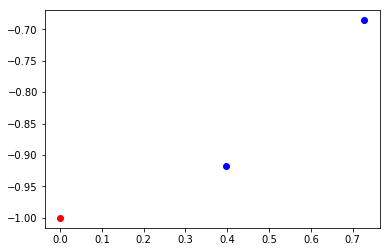

Pred Results
Score:  7.4412439119948575


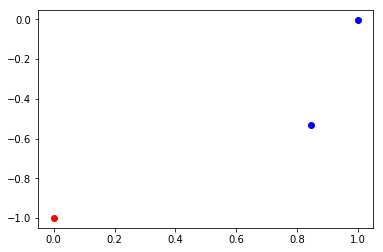

Prey Results
Score:  -28.883148034106227


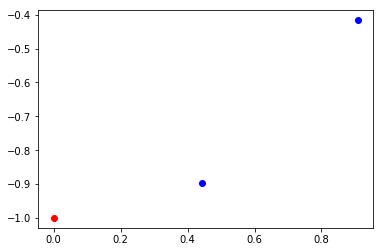

Pred Results
Score:  28.883148034106227


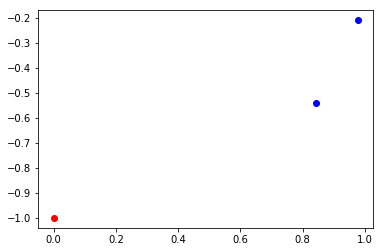

Prey Results
Score:  -25.080342521194442


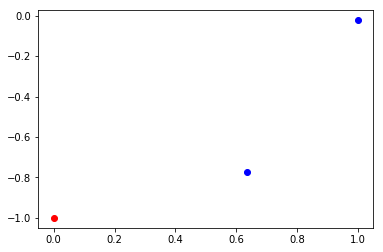

Pred Results
Score:  25.080342521194442


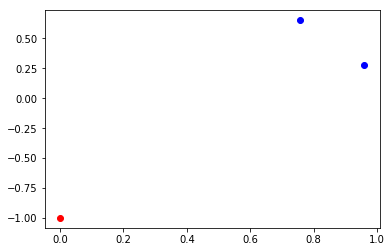

Prey Results
Score:  -97.55319344892358


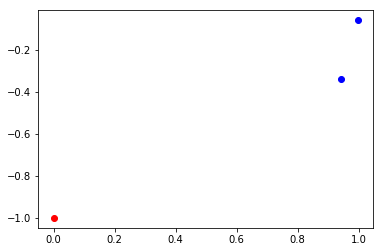

Pred Results
Score:  97.55319344892358


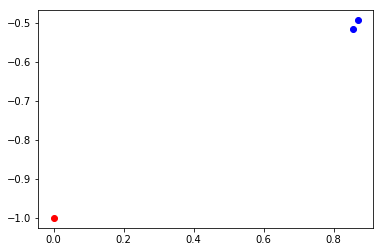

Prey Results
Score:  -8.283171618303427


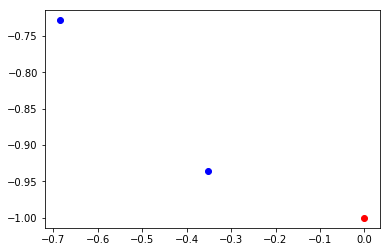

Pred Results
Score:  8.283171618303427


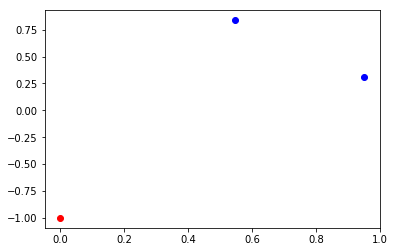

Prey Results
Score:  -17.764132323088404


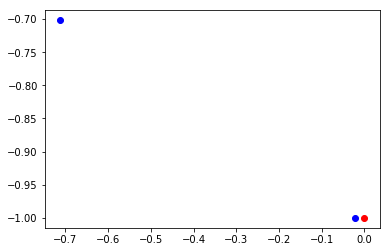

Pred Results
Score:  17.764132323088404


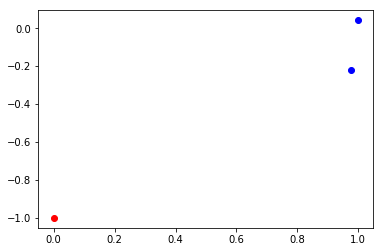

In [577]:
for result in results:
    # Output Prey Results
    print("Prey Results")
    print("Score: ", result[2][1])
    plt.plot(cos((3*pi)/2), sin((3*pi)/2), 'ro', c="red")    
    plt.plot(cos(result[0][0].eye_arclength), sin(result[0][0].eye_arclength), 'ro', c="blue") 
    plt.plot(cos(result[0][1].eye_arclength), sin(result[0][1].eye_arclength), 'ro', c="blue") 
    plt.show()
    # Output Pred Results
    print("Pred Results")
    print("Score: ", result[2][0])
    plt.plot(cos((3*pi)/2), sin((3*pi)/2), 'ro', c="red")    
    plt.plot(cos(result[1][0].eye_arclength), sin(result[1][0].eye_arclength), 'ro', c="blue")    
    plt.plot(cos(result[1][1].eye_arclength), sin(result[1][1].eye_arclength), 'ro', c="blue")    
    plt.show()


In [583]:
avg_prey_length = sum([abs(result[0][0].eye_arclength - result[0][1].eye_arclength) for result in results])/len(result)
avg_prey_length

3.6658073442180084

In [584]:
avg_pred_length = sum([abs(result[1][0].eye_arclength - result[1][1].eye_arclength) for result in results])/len(result)
avg_pred_length

3.0618969517421735